In [1]:
## This Script takes a single or multiple process HDF5 files containing multiple channels, phases them together and plots them on a single graph. 
## The Files, Axis displays, Channel the recordings are phased together using and the amplitude are all user definable. 
## Ensure that all input files have the same number of columns and column order. The script prints the files and their repective channels at the start of the script. 



### NEED TO ADD FUNCTION THAT SPECIFIES THE LIMITS OF THE PHASING - IE TELLS YOU TO CHOOSE A VALUE WITHIN A RANGE. 

#Imported Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
from os.path import isfile, join
import h5py
from datetime import date
import matplotlib.lines as mlines
import matplotlib.figure as fig
import math # Used for min and max Y axis values.


#SETTING THE BASE DIRECTORY FOR THE PYTHON SCRIPT - IMPORTANT

#os.chdir(os.path.dirname(os.path.abspath(__file__))) # UN-HASH WHEN CONVERTED TO .PY SCRIPT. Used to set base directory in python terminal to enable relative input and output folder names to be used. 


# CONSTANTS 

InputFolder = "./Processed_HDF5_Files" # input file path
OutputFilePath = "Output_Plots" # Output Folder

# Color Dictionary Map for Plot
CMAP={ 0:"#1f77b4",1:"#ff7f0e", 2:"#2ca02c", 3: "#d62728",4:"#9467bd",5:"#8c564b", 6: "#8c564b", 7:"#7f7f7f", 8:"#bcbd22", 9:"#aec7e8", 10:"#ffbb78", 11:"#98df8a", 12:"#ff9896", 13:"#c5b0d5",14:"#c49c94",15:"#f7b6d2", 16:"#c7c7c7", 17:"#dbdb8d" } # color map dictionary


#Phasing Variable Setup
PhasingPointTime = 0 # setting up variable. Used in Phase function and gets set to the greatest time at which a certain amplitude value is reached in a specific dataset. 
TimeAfter = 0 # Setting up variable. Calculates the greatest time after the PhasingPointTime and the end of a dataset. 


# Plotting Variables
XScaleMin=-2 #scaling for X Axis - MIN - Assuming Time - Gives a good buffer to the left hand side.  - NOT CURRENTLY USED


# Functions

def InputVariableNumberCheckerFloat(Value,Defaultvalue): # function confirms input string can be converted to a float. If not it returns a default value which is given as the second arugment with the function.  
    try:
        float(Value) # try to see if the value can be converted to a float. If it can the function just returns the input argument
        return Value    
    except ValueError: # if the above returns an error it tells the user and then returns the default value argument
        print(f"Suitable value not inputted. Default value of {Defaultvalue} is used instead")
        return Defaultvalue
        
def InputVariableNumberCheckerInt(Value,Defaultvalue): # function confirms input string can be converted to a integer. If not it returns a default value. 
    try:
        int(Value) # try to see if the value can be converted to a integer. If it can the function just returns the input argument
        return Value    
    except ValueError: # if the above returns an error it tells the user and then returns the default value argument
        print(f"Suitable value not inputted. Default value of {Defaultvalue} is used instead")
        return Defaultvalue

def FileSelectionNumberCheck(Input, MaxNumber): # Checks that the values inputted are actually integers and is a value less than the max number of files found in the folder. 
    
    for ListItem in Input:
        try:
            int(ListItem) # try to see if the value can be converted to a integer. If it can the function just returns the input list
            

        except ValueError: # if the above returns an error it asks again for the user to input a correct number
            ErrorInputString = input("A non-integer or space was inputted. Numbers seperated by spaces only! Try again ->   ")
            ErrorInputList = ErrorInputString.split(" ")
            Input = AxisNumberCheck(ErrorInputList, MaxNumber) # performs the NumberCheck function again to confirm that a number was inputted the second time. 
        
        else:
            if int(ListItem) < 0 or int(ListItem) > MaxNumber:
                ErrorInputString = input(f"A value greater than the number of files in the input folder was inputted. There are only {MaxNumber} files! Try again ->   ")
                ErrorInputList = ErrorInputString.split(" ")
                Input = AxisNumberCheck(ErrorInputList, MaxNumber) # performs the NumberCheck function again to confirm that a number was inputted the second time. 
                
    return Input

def AxisNumberCheck(Input, MaxNumber): # Checks that the value inputted it actually an integer. If not continues to ask until a Integer is inputted
    
    for ListItem in Input:
        try:
            int(ListItem) # try to see if the value can be converted to a integer. If it can the function just returns the input list
            

        except ValueError: # if the above returns an error it asks again for the user to input a correct number
            ErrorInputString = input("A non-integer or space was inputted. Numbers seperated by spaces only! Try again ->   ")
            ErrorInputList = ErrorInputString.split(" ")
            Input = AxisNumberCheck(ErrorInputList, MaxNumber) # performs the NumberCheck function again to confirm that a number was inputted the second time. 
        
        else:
            if int(ListItem) < 0 or int(ListItem) > MaxNumber:
                ErrorInputString = input(f"A value greater than the number of channels in the recording was inputted. There are only {MaxNumber} channels! Try again ->   ")
                ErrorInputList = ErrorInputString.split(" ")
                Input = AxisNumberCheck(ErrorInputList, MaxNumber) # performs the NumberCheck function again to confirm that a number was inputted the second time. 
                
    return Input

def DatasetList(File): # Function that opens the arugment file - needs to be a legit filename - and extracts channel descriptions
    global DataListCounter
    hdf5Import = h5py.File("./%s"%(File), "r") # opening the file as the variable hdf5Import
    ChannelDescriptions = list(hdf5Import["Data"].attrs["ChannelDescriptions"]) #importing the different attributes associated with the dataset channels
    RecordingLength = hdf5Import["Data"].attrs["SampleLength"]
    hdf5Import.close() # closes the file - very important

    NumberofColumns = int(len(ChannelDescriptions))-1 # calculates the number of dataset columns 
    Counter = 0
    print(f"File {DataListCounter} = {File[17:]} is {RecordingLength} seconds long and contains ", end="") # The use of the end="" means that the print function does not post a /n new line instruction. This means that subsequent print commands print on the same line. 
    for B in ChannelDescriptions: # this for function cycles through the list items generated from the first line and basically prints the value of a counter that icrements as the loop progresses and the column header. 
        if Counter == NumberofColumns:
            print(f"{Counter + 1}.{ChannelDescriptions[Counter]}")
        else:
            print(f"{Counter + 1}.{ChannelDescriptions[Counter]}, ", end="")
            Counter += 1
    DataListCounter += 1
        
def GlobalReferencePoint(File,Channel): # function that figures out the greatest time (seconds) at which a certain phasing amplitude value is reached and the greatest time of a dataset after the Y value is reached.  
    #Variables
    
    global TriggerAmplitude
    global PhasingPointTime # global variable for the longest time the trigger is reached out of all the data run through the function. 
    
    global TimeAfter
    global TriggerRisingFalling

            
    
    YPhaseOffset = 0 # setting up offset value

    # Importing the phasing channel from each individual file
    hdf5Import = h5py.File("./%s"%(File), "r") # opening the file as the variable hdf5Import
    Data = np.array(hdf5Import["Data"][:,Channel])
    SampleTime = hdf5Import["Data"].attrs["SamplePeriod"]
    hdf5Import.close() # closes the file - very important

    
    # the following If function looks to see if the trigger is falling or not. If the user input equals falling, Falling or FALLING the compare function is < ie if the trigger is below the trigger point
    
    if TriggerRisingFalling == "Falling" or TriggerRisingFalling == "falling" or TriggerRisingFalling == "FALLING":
        
        YPhaseOffset = np.where(Data <= TriggerAmplitude)[0][0]

        
    else:
        YPhaseOffset = np.where(Data >= TriggerAmplitude)[0][0]     

    InstanceTimeAfter = round((len(Data) - YPhaseOffset) * SampleTime, ndigits=3) # calculating the time after the y value is reached and the end of the dataset. 

    TriggerTime = round(SampleTime * YPhaseOffset,ndigits=6) # the result from the for function is turned into a time via the sampletime extracted from the HDF5 attributes. 
    del Data # delete that variable data - attempt to limit memory usage. 
    if TriggerTime > PhasingPointTime:
        PhasingPointTime = TriggerTime # if the time for this set is greater than all the other datasets looked at PhasingPoint variable is updated.  
    if TimeAfter < InstanceTimeAfter:
        TimeAfter = InstanceTimeAfter # if the time for this set is greater than all the other datasets looked at TimeAfter variable is updated.  

def AxisDataInitial(File, Channel): # Initially populating the global Y axis scale list with data
    global GlobalYAxisPlotValues
    global TotalNumberOfYScaleValues

    hdf5Import = h5py.File("./%s"%(File), "r") # opening the file as the variable hdf5Import
    YScaleValues = list(hdf5Import["Data"].attrs["YScales"])
    hdf5Import.close() # closes the file - very important
    
    GlobalYAxisPlotValues.append(YScaleValues[Channel*2]) # adds the y min value to the list
    GlobalYAxisPlotValues.append(YScaleValues[(Channel*2)+1]) # adds the y max value to the list
        

def AxisLabelChecker(File,Original,New): # If whilst generating the Master Y axis scale list a discremancies for a given channel between files is found the user is promted as to whether the scale value should be updated. 
    global ChannelDescription 
    UpdateValue = input(f"Processing the dataset {File[17:]}  whilst trying to generate {ChannelDescription} Axis limits. The Original Value was {Original}, the program is trying to update it to {New}. DO YOU WANT TO DO THIS? Yes or No ->    ")
    if UpdateValue == "YES" or UpdateValue == "Yes" or UpdateValue == "yes": # use of different spelling of yes to ensure it progresses issue free.    
        return True
    else:
        return False

def AxisData(File, Channel): # This function is applied to subseqeunt files (after AxisDataInitial has been run once) to see if the channels in other files have the same Y axis limit values. If not it prompts the user if the global values should be updated. 
    global GlobalYAxisPlotValues
    global TotalNumberOfYScaleValues
    global NumberOfChannels
    global ChannelDescription
    global ProposedPlotAxisData
    global ChannelAssessing
 
    hdf5Import = h5py.File("./%s"%(File), "r") # opening the file as the variable hdf5Import
    YScaleValues = list(hdf5Import["Data"].attrs["YScales"])
    hdf5Import.close() # closes the file - very important
    
    
    ProposedPlotAxisData = [] # set up list for proposed axis values
    
    # Remember that within GlobalYAxisPlotValues the list is arranged [ Channel A min, Channel A Max, Channel B Min, Channel B Max.....] ie each channel Y axis values are in sets of 2. 
    # for loop that cycles through the code generating an list of lits of YAxis values in the form [[Channel A min, Channel A Max],[Channel B min, Channel B Max]]
    # Done this way to enable easier indexing when calling for the values alter on. ie assigns the min and max values to a single index position, which can then be subquently indexed by [0] and [1]
    
    ProposedPlotAxisData.append(YScaleValues[Channel*2]) # adds the y min value to the list
    ProposedPlotAxisData.append(YScaleValues[(Channel*2)+1]) # adds the y max value to the list
 
    YMinOriginal =  GlobalYAxisPlotValues[0] # element within that sublist
    YMaxOriginal =  GlobalYAxisPlotValues[1]
   
    YMinNew=ProposedPlotAxisData[0]
    YMaxNew=ProposedPlotAxisData[1] 

    AxisUpdateRequired = False # sets up a trigger boolean variable. if any values need to be updated this forces the system to prompt the user if to update the sublist. 
    if YMinOriginal != YMinNew: # is the oringal and new min value different. If so ask if it should be updated. 
        Update = AxisLabelChecker(File, YMinOriginal,YMinNew)
        if Update == True:
            YMinOriginal = YMinNew # if true update the oringial min value with the new value. 
            
            AxisUpdateRequired = True
    if YMaxOriginal != YMaxNew:
        Update = AxisLabelChecker(File, YMaxOriginal,YMaxNew)
        if Update == True:
            YMaxOriginal = YMaxNew
            
            AxisUpdateRequired = True                
    if AxisUpdateRequired == True: # if either has been updated resave the axis values. 
        GlobalYAxisPlotValues = [YMinOriginal,YMaxOriginal]

def AdjustAndPlot(File, Channel):
# Adjustment and plot function. Primary Function
# Function used within a for loop inputting the dataset files into the function

# Function initally loads the data channel identified as the data to phase together. 
# The adjustment code calculates the size of the array that needs to be inserted before all the channels in that dataset file to bring it into phase. 

# The function then runs a for loop that loads the data channels from the input file one by one. 
# It applies an array of NaN (Not A Number) values to the start of each column loaded. 
# The time values are then generated via the sampletime values extracted from the source file. 
# The function then plots the data as a twinx (ie share x values), extracts the scaling data from the GlobalYAxisPlotValues list from the previous function and then hides the axis labels/numbers.
# Plot attributes like labels are applied to lines but hidden. Recalled up later in the main program.  
    
    
    global GlobalYAxisPlotValues
    global ax1
    global TriggerAmplitude
    global PhasingPointTime # global variable for the longest time the trigger is reached out of all the data run through the function.
    global LineWeightCount
    global TriggerRisingFalling
    
    global ImportFileList
   # global FileNameLegendLineList
    global LineWeightIncrement
    global PlotCounter
    global DerivEnable
    global DerivAxisLimits
    
   
    ####   Adjustment Function   ####

    ## Importing the phasing channel data and sample period. 

    hdf5Import = h5py.File("./%s"%(File), "r") # opening the file as the variable hdf5Import
    Data = np.array(hdf5Import["Data"][:,Channel]) # COULD CHANGE PHASING COLUMN TO SINGLE COLUMN IMPORT NUMBER
    SampleTime = hdf5Import["Data"].attrs["SamplePeriod"]
   
        
    
    
    # the following If function looks to see if the trigger is falling or not. If the user input equals falling, Falling or FALLING the compare function is < ie if the trigger is below the trigger point
    if TriggerRisingFalling == "Falling" or TriggerRisingFalling == "falling" or TriggerRisingFalling == "FALLING":
        
        YPhaseOffset = np.where(Data <= TriggerAmplitude)[0][0]

        
    else:
        YPhaseOffset = np.where(Data >= TriggerAmplitude)[0][0] 
    
    ## Generating the required offset in terms of cells
    YOffset = ((PhasingPointTime - (YPhaseOffset*SampleTime))/SampleTime) # finding the difference between the output of the phase function and the point at which the trigger value is reached in this dataset
    YOffset = int(YOffset) # turn it into a integer from a float - required as float introduces error. np.zeros cannot use float value. 

    
    
      
    ## At this point ive loaded the dataset of the single channel and foud the offset required. 
    ## Line weight change with each channel, color with each file. 
    ## generate derivative first - ie generate a 2 column array.  
    ## apply offset dataset  
    ## plot each column in a for loop. 
    
    
    
    AdjustmentArray = np.empty(YOffset) # generate an empty array the size required for the adjustment offset. 
    AdjustmentArray[:] = np.nan # populate that array with NaN values. 
    Data = np.insert(Data, 0,AdjustmentArray) # insert that array to the beginning of the data values to generate the offset. NaN values do not plot. 
    
    if DerivEnable == True: # generate the derivative data set if requested earlier in the function. new array. 
        DerivData = signal.savgol_filter(Data, 120, 1, delta= SampleTime, mode="mirror", deriv=1)

    ## Time Array generation. 
    temptime = Data.shape[0]*SampleTime # finding the shape of the Data array and converting it to a time value. 
    TimeData = np.arange(0,temptime,SampleTime) # generaing the X time array. 

    if TimeData.shape[0] != Data.shape[0]: # if the number of x values differs from the number of y. using shape function that outputs list [r, c]. Indexed for column. 
        C = TimeData.shape[0] - Data.shape[0] # calculate the difference between the two arrays
        if C > 0: # if the difference is greater than 1, ie more x values than y, delete the difference from the end of the array. 
            TimeData = np.delete(TimeData, -C) # https://numpy.org/doc/stable/reference/generated/numpy.delete.html

    AlphaCount = 0.9 # alpha value set point for plotted data - Can be lowered to increase/add transpancy to the plots to aid with visualisation. 

    ## Plotting the raw dataset - Label of the filename. 
    ax1.twinx().plot(TimeData,Data, lw=1.4, color= CMAP[PlotCounter], alpha = AlphaCount, label = File[21:-5])
    
    plt.ylim(bottom=GlobalYAxisPlotValues[0], top=GlobalYAxisPlotValues[1]) # Axis data for that column from the GlobalYAxisPlotValues. Ensures scaling on the plot
        
    plt.gca().get_yaxis().set_visible(False) # hide axis and labels. 
    
    if DerivEnable == True: # Plotting the Deriviative dataset if enabled. 
        ax1.twinx().plot(TimeData,DerivData, lw=0.7, color= CMAP[PlotCounter], alpha = AlphaCount)
        plt.ylim(bottom=DerivAxisLimits[0], top=DerivAxisLimits[1]) # Axis data for that column from the GlobalYAxisPlotValues. Ensures scaling on the plot
        plt.gca().get_yaxis().set_visible(False) # hide axis and labels. 
    
    hdf5Import.close() # closes the file - very important

    


In [2]:
#HDF5 Fiile List Generation
ImportFileList = [f for f in os.listdir(InputFolder) if isfile(join(InputFolder, f))] # look through the folder specified in the variable above and generate a list of all the files within that folder. 
InputFolder = InputFolder[2:] + "/" # converting the file path input constant to work correctly with susequent open/import requests
ImportFileList = [InputFolder + s for s in ImportFileList] # Adds the filepath to the file name so it can be easily used by following import/open functions

print("\n") # Spacer for good readability within terminal. 

DataListCounter = 1 # Counter set up for below
for a in ImportFileList: # function that generates a list of the files and dataset columns in all the files within the input folder as defined at the start. 
    
    DatasetList(a)



File 1 = les/TestFile1.hdf5 is 62.9 seconds long and contains 1.Engine Speed, 2.A Bank Inlet Manifold, 3.Fuel Flow


In [3]:
## File Selection - input the files to be plotted in the desired order - Check function checks that the input is valid - map() function to ensure all elements within the inputted list are integers
## A Temporary file list is generated - pulling the values from the oringial file list using the inputted numbers as an index (-1). FileList is then updated to reflect just the list of files selected. 
## A undated file list is printed with the channels displayed and recording duration. 

FileSelectionList = input("\nWhich Files do you want to plot? State the File number in the desired order - input integers and spaces only - for example 1 6 3..... ->   ")
FileSelectionList = FileSelectionList.split(" ") # splitting string full of numbers (hopfully) into a list. 
FileSelectionList = FileSelectionNumberCheck(FileSelectionList, len(ImportFileList)) # checking that all the values in the list are actually numbers
FileSelectionList = map(int, FileSelectionList) # map function argument (function, list to apply it to) - ie applies the int function to each list element within FileSelectionList
TemporaryFileSelectionList = []
for FS in FileSelectionList:
    TemporaryFileSelectionList.append(ImportFileList[FS-1]) # FS-1 to get the correct indexing
ImportFileList = TemporaryFileSelectionList
DataListCounter = 1
for a in ImportFileList: # function that generates a list of the files and dataset columns in all the files within the input folder as defined at the start. 
    
    DatasetList(a) # Recalling the same function as before. 

File 1 = les/TestFile1.hdf5 is 62.9 seconds long and contains 1.Engine Speed, 2.A Bank Inlet Manifold, 3.Fuel Flow


In [4]:
## Generating a list of channel to use in each file



ImportFileChannel = [] # generating the base line list. End up as list of a lists containing filename,channel
DataListCounter = 1 # Counter

def ChannelSelector(File): # Function that opens the arugment file - needs to be a legit filename - and extracts channel descriptions. User selects which channel should be processed. File name and channel number saved as a list within ImportFileChannel
    global DataListCounter # Counter for string generation for file number in question
    global ImportFileChannel # Output List of Lists (File,Channel)
    global PhasingRange
    
    hdf5Import = h5py.File("./%s"%(File), "r") # opening the file as the variable hdf5Import
    ChannelDescriptions = list(hdf5Import["Data"].attrs["ChannelDescriptions"]) #importing the different attributes associated with the dataset channels
    
    
    
    
    # hdf5Import.close() # closes the file - very important

    NumberofColumns = int(len(ChannelDescriptions))-1 # calculates the number of dataset columns 
    Counter = 0 # Counter for string generation
    QuestionString = "File %s (%s) contains"%(DataListCounter,File[17:]) # Generates a initial string that gets drawn into the question in the irrative loop below. 
    for B in ChannelDescriptions: # this for function cycles through the list items and adds to the QuestionString string. Generating the string for the input question to come.  
        QuestionString = "%s %s - %s,"%(QuestionString,Counter + 1,ChannelDescriptions[Counter])
        Counter += 1
    ChannelSelector = input(f"\nChannel Selector - {QuestionString[0:-1]}. \nPlease select the Channel to process. Input = Single Integer. 1, 2, 3 etc. The default is Channel 1 ->   ")  # Find that %s doesnt work. Question using to the strings above. 
    ChannelSelector = InputVariableNumberCheckerInt(ChannelSelector,1) # Checking the inputted value is an Int
    ChannelSelector = int(ChannelSelector)-1 # Converting it to a viable index position
    if ChannelSelector < 0 or ChannelSelector > NumberofColumns: # checker that the value is valid
        ChannelSelector = 0
        print("The number entered is not a valid Channel. Channel 1 will be processed")
    
    ImportFileChannel.append([File,ChannelSelector]) # Adding the file name and selected channel to the global list. 

    ChannelData = np.array(hdf5Import["Data"][:,ChannelSelector]) # Imports the Array data for the channel Selected.
    ImportSignalMIN = np.min(ChannelData) # Finds the minimum value recorded in the imported channel array data
    ImportSignalMax = np.max(ChannelData) # Finds the Max value in the array. 
    if PhasingRange[0] == 0:
        PhasingRange[0] = ImportSignalMIN
    elif ImportSignalMIN <= PhasingRange[0]:
        PhasingRange[0] = ImportSignalMIN
    if ImportSignalMax >= PhasingRange[1]:
        PhasingRange[1] = ImportSignalMax

    del ChannelData
    hdf5Import.close() # closes the file - very important
    DataListCounter += 1


PhasingRange = [100,0]
for a in ImportFileList: # Generation of a list of [File name, Channel] for later processing. 

    ChannelSelector(a) # Function above. 


In [5]:
## User input to select which of the selected files to take channel discriptions and channel units from. 

ChannelDescriptionImportFileNumber = input("\nWhich File do you want to take the Channel Description and Units from? 1, 2, 3....? The default is File 1->   ")  # asks the question about which file to process. Wants an input. 
ChannelDescriptionImportFileNumber = InputVariableNumberCheckerInt(ChannelDescriptionImportFileNumber,1)
ChannelDescriptionImportFileNumber = int(ChannelDescriptionImportFileNumber)-1 # Converting the value into an number that works as an index for a list. 
if ChannelDescriptionImportFileNumber > len(ImportFileList)-1: # Checking that the value is actually a legit value, ie that there is a list index position for the number inputted or that 0 hasnt been inputted
    ChannelDescriptionImportFileNumber = 0
    print("The number entered is greater than the number of datasets available. The Channel descriptions will be taken from file 1")

ChannelDescriptionImportIndexValue = ImportFileChannel[ChannelDescriptionImportFileNumber][1]
hdf5Import = h5py.File("./%s"%(ImportFileList[ChannelDescriptionImportFileNumber]), "r") # opening the file as the variable hdf5Import
ChannelDescription = list(hdf5Import["Data"].attrs["ChannelDescriptions"])[ChannelDescriptionImportIndexValue] #importing the different attributes associated with the dataset channels
ChannelUnits = list(hdf5Import["Data"].attrs["ChannelUnits"])[ChannelDescriptionImportIndexValue]
hdf5Import.close() # closes the file - very important

for ND in ChannelDescription: # Checking that the desired file to take description data from doesnt have a NO DATA Column. If it does the program quits. 
    if ND == "NO DATA":
        print("The Dataset selected includes a NO DATA channel")
        input("The Dataset selected includes a NO DATA channel. Choose a different File to take Channel Descriptions from next time. Press any key to exit  ")
        quit()

        




In [6]:
## User input to define which Channel the recordings are going to be phased together at. The desired amplitude is then requested. Both values checked to be an int and float respectivly. 
## User then asked whether a rising or falling trigger condition should be used for the phasing function. 


TriggerAmplitude = input(f"Define the amplitude all the datasets are to be phased together at. Permissible value must be between {PhasingRange[0]} and {PhasingRange[1]}  ->   ") # input to define the phasing value 
TriggerAmplitude = InputVariableNumberCheckerFloat(TriggerAmplitude,200)
TriggerAmplitude = round(float(TriggerAmplitude),2)

TriggerRisingFalling = input("Rising or Falling trigger. Default is Rising ->   ")
print("")

for a in ImportFileChannel: # function cycles through the files and calculates the overall greatest time for all the datasets to phase together at. 
    # File = a[0]
    # Channel = a[1]
        
    GlobalReferencePoint(a[0],a[1])

PhasingPointTime += 1 # 1 second added to minimise rounding errors. 


In [7]:
DerivEnable = input("\nDo you want to display the DERIVATIVE of the plotted data? ->   Yes or No?  Empty return = No  ")
if DerivEnable == "YES" or DerivEnable == "Yes" or DerivEnable == "yes":
    DerivEnable = True


def DerivAxisFunction(File, Channel):
    global DerivAxisLimits

    
    
    hdf5Import = h5py.File("./%s"%(File), "r") # opening the file as the variable hdf5Import
    Data = np.array(hdf5Import["Data"][:,Channel]) # COULD CHANGE PHASING COLUMN TO SINGLE COLUMN IMPORT NUMBER
    SampleTime = hdf5Import["Data"].attrs["SamplePeriod"]
    hdf5Import.close()

    DerivData = signal.savgol_filter(Data, 120, 1, delta= SampleTime, mode="mirror", deriv=1)

    DerivminValue = round(float(np.nanmin(DerivData[DerivData != -np.inf])),4)  # finds the min value in the channel dataset but only looks at values that are not infinate. 
    DerivmaxValue = round(float(np.nanmax(DerivData[DerivData != np.inf])),4)     # Finds the Max Value
        
    DerivSpan = round((DerivmaxValue - DerivminValue),4) # finds the span of Y values (not including inf) from the min and max values
    DerivAxisSpacingPercentEitherSide = 10 # variable to define the buffer either side ## MIGHT WANT TO ADJUST THIS
    ValueBuffer = round(DerivSpan * (DerivAxisSpacingPercentEitherSide/100), 4) # calcultes this percentage as an actual value relative to the span. 
    
    Ymin = math.floor(DerivminValue - ValueBuffer) # finds the new min value, rounded down to the nearest number. 
    Ymax = math.ceil(DerivmaxValue + ValueBuffer)

    if DerivSpan <= 2:
        Ymin = round((DerivminValue - ValueBuffer),3) # finds the new min value, rounded down to the nearest number. 
        Ymax = round((DerivmaxValue + ValueBuffer),3) # finds the nex max value, rounded up to the nearest number. 

    if len(DerivAxisLimits) == 0:
        DerivAxisLimits = [Ymin, Ymax]
    
    else:
        if DerivAxisLimits[0] > Ymin:
            DerivAxisLimits[0] = Ymin
        if DerivAxisLimits[1] < Ymax:
            DerivAxisLimits[1] = Ymax

def OrderMagnitudeScaling(AxisValues): # takes a set of axis values and rounds it depending on its magnitude of the span.
    Span = AxisValues[1]-AxisValues[0]
    if 1000 > Span >= 10:
        AxisValues[0] = math.ceil(AxisValues[0] / 10.0) * 10 
        AxisValues[1] = math.ceil(AxisValues[1] / 10.0) * 10 
    if 10 > Span >= 2:
        AxisValues[0] = int(AxisValues[0])
        AxisValues[1] = int(AxisValues[0])
   



    return AxisValues

if DerivEnable == True:
    import math # Used for min and max Y axis values.
    DerivAxisLimits = []



    for Element in ImportFileChannel:
        DerivAxisFunction(Element[0],Element[1])



    DerivAxisLimits = OrderMagnitudeScaling(DerivAxisLimits)

    DerivAxisChecker = input(f"\nThe calculated derivative axis min/max values are {DerivAxisLimits[0]} and {DerivAxisLimits[1]}, if you want to change these return any value other than a return ->   ")
    if len(DerivAxisChecker) != 0:
        DerivAxisLimits[0] = round(float(input(f"The automatic MIN Y axis value for {ChannelDescription} is {DerivAxisLimits[0]}. Type in new value->   ")),3)
        DerivAxisLimits[1] = round(float(input(f"The automatic MAX Y axis value for {ChannelDescription} is {DerivAxisLimits[1]}. Type in new value->   ")),3)



In [8]:
### Primary function is to generate a master min and max Y values for each of the channels taking into account that the input files might have been processed with different values. 
## Intially the first file inspected is used to generate an intial list. 
## Subsequent files are then inspected. If the min or max value differs the user is prompted to confirm if the master list should be updated. 
## The min and max values from the master list are then declared and the user has the option to manually change them. 

GlobalYAxisPlotValues = [] # setting up the initial list
#NumberOfChannels = len(ChannelDescription)

for a in ImportFileChannel: # for loop that cycles through the datasets. If the list is not populated it inities the generation function. otherwise it runs the function that can update if required. 
    if len(GlobalYAxisPlotValues) == 0: 
        AxisDataInitial(a[0],a[1])
    else:
        AxisData(a[0],a[1])

#Axis Checking Function

AxisChecker = input(f"\nThe calculated {ChannelDescription} axis min/max values are {GlobalYAxisPlotValues[0]} and {GlobalYAxisPlotValues[1]}, if you want to change these return any value other than a return ->   ")
if len(AxisChecker) != 0:
    GlobalYAxisPlotValues[0] = round(float(input(f"The automatic MIN Y axis value for {ChannelDescription} is {GlobalYAxisPlotValues[0]}. Type in new value->   ")),2)
    GlobalYAxisPlotValues[1] = round(float(input(f"The automatic MAX Y axis value for {ChannelDescription} is {GlobalYAxisPlotValues[1]}. Type in new value->   ")),2)
    



In [9]:
## Variable List
# GlobalYAxisPlotValues = List with Ymin, Ymax Values
# ImportFileChannel = List of lists containing file, channel
# TriggerAmplitude = Phasing Amplitude
# PhasingPointTime = time value
# TriggerRisingFalling = enable the trigger. 


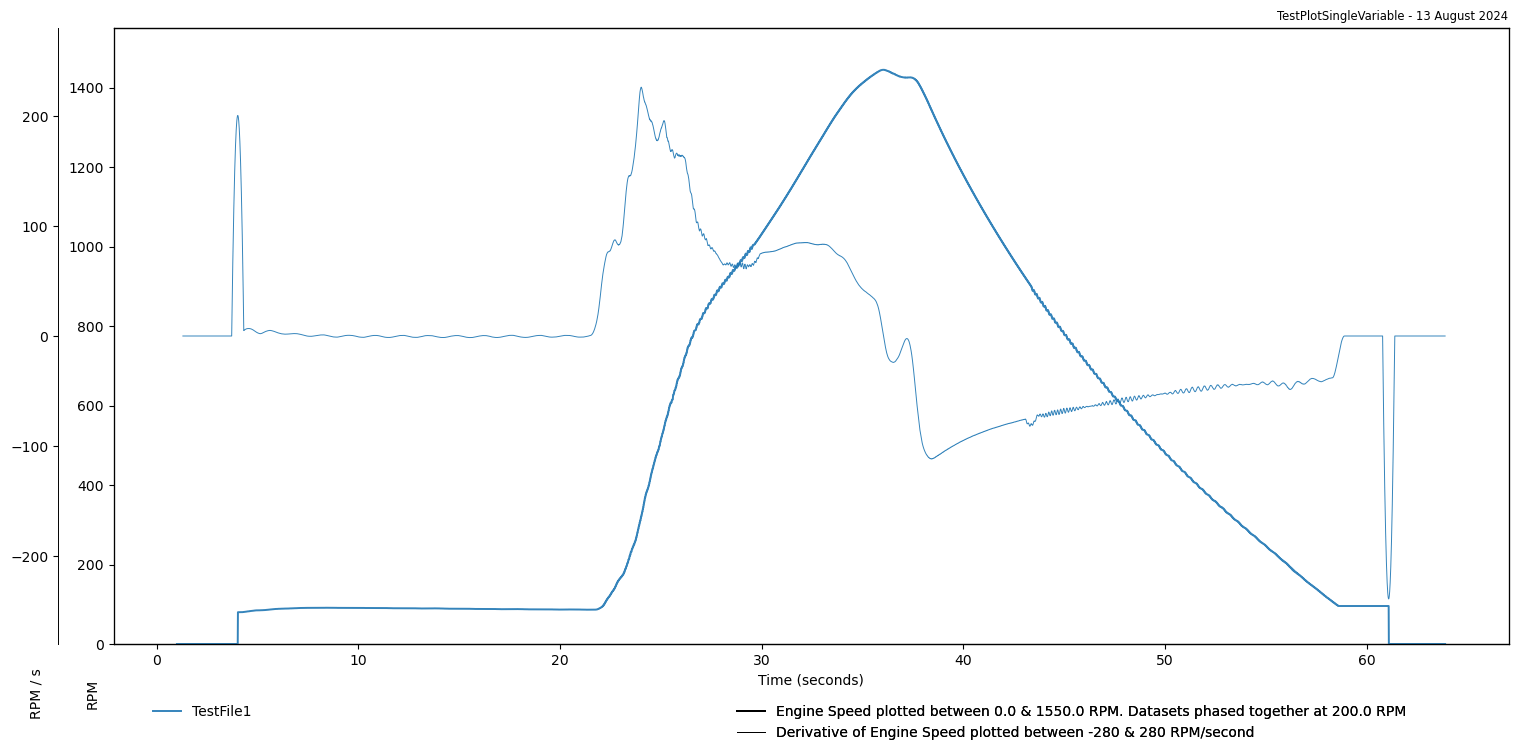

In [10]:

 
#XScaleMax = PhasingPointTime + TimeAfter # Scaling for X Axis - MAX - NOT CURRENTLY USED!

## Generating the base plot
fig, ax1 = plt.subplots(figsize = (18,8)) 
ax1.plot() 

## Plot Title Generation - User defined or defaults to just the date. 
PlotTitle = input("\nType in the desired Plot Title ->   ")
if PlotTitle == "":
    PlotTitle = "%s"%(date.today().strftime("%d %B %Y"))
else:
    PlotTitle = "%s - %s"%(PlotTitle, date.today().strftime("%d %B %Y"))

plt.title(PlotTitle, loc="right", fontsize = "small")

##  Initial plot labelling and Y axis generation
plt.ylabel(ChannelUnits) #Primary Y axis UNIT label inserted. PhasingColumn-1 used to get correct list indexing position. 
ax1.yaxis.set_label_coords(-0.01, -0.08)    # Positioned unit label under the axis itself - Trial and error - Small (0.001) changes have notable effect. 
plt.xlabel("Time (seconds)") # X axis label applied
plt.ylim(bottom=GlobalYAxisPlotValues[0], top=GlobalYAxisPlotValues[1]) # Defing the primary plot Y axis values from the Phasing Channel index position

   

Offset = 40 # Offset used to locate the additional Y axis positioning. Increments through += code within the adjustandplot function as an extra Y axis is plotted. 
LabelOffset = -0.05 # Offset for positioning additional Y axis labels.

## For function that ultimatly generates the additional Y axis on the plot. Goes through the axis defined by the user to be shown, checks to see that its not a phasing column and then intiates the AxisPlotter function. 
#for AxisIndex in AxisList:

 #   if AxisIndex != PhasingColumn:
  #      AxisPlotter(AxisIndex, Offset, LabelOffset)
   #     ## Interating values for positional locating variables for subsequent axis being plotted. 
    #    Offset += 40
     #   LabelOffset -= 0.04

if DerivEnable == True:

    #DerivYmin = -150
    #DerivYmax = 250

    Ax2 = ax1.twinx() # shortening the command ax1.twinx() to Ax2 for easier programming below. 
    Ax2.set_ylim(DerivAxisLimits[0], DerivAxisLimits[1]) # sets the limits for the axis.

    ## Following spines commands define the location, lineweight and color of the additional axis. 

    Ax2.spines['left'].set_position(('outward', Offset)) # offset is a input argument into the function. 
    Ax2.spines['left'].set_color("black")
    Ax2.spines['left'].set_visible(True)
    Ax2.spines['right'].set_visible(False)
    Ax2.spines['left'].set_linewidth(0.7)
    Ax2.yaxis.set_label_position('left')
    Ax2.yaxis.set_ticks_position('left')
    Ax2.tick_params(axis='y', colors=("Black"))    

    Ax2.set_ylabel("%s / s"%(ChannelUnits), color=("Black")) #generats the unit label for the axis. 
    Ax2.yaxis.set_label_coords(LabelOffset, -0.08) # labeloffset is a function argument. Its an incrementing value. Defines the location of the axis label.  


## Plotting reference setup - LineweightCounter - largest lineweight drawn. 

PlotCounter = 0
UnitLegendLineList = []

## Primary plotting function. Generates all the data plots. Incremenets through each file to be plotted with the additional channel argument sent. 
for a in ImportFileChannel:
    
    AdjustAndPlot(a[0], a[1])
    PlotCounter += 1

   
## Data for the additional legend that defines what each lineweight means - ie raw data for thick and the derivative for the thinner line. Second element only appended to list if DerivEnable is true. 
UnitLegendLineList.append(mlines.Line2D([], [], color='Black', lw=1.4, markersize=15))
if DerivEnable == True:
    UnitLegendLineList.append(mlines.Line2D([], [], color='Black', lw=0.7, markersize=15))

# Generating the addtional legend showing the file names with an assoaited lineweight for the files plotted. # See OneNote for explination. 
DerivUnit = "%s/second"%(ChannelUnits)
LegendUnitList = ["%s plotted between %s & %s %s. Datasets phased together at %s %s"%(ChannelDescription, GlobalYAxisPlotValues[0], GlobalYAxisPlotValues[1], ChannelUnits, TriggerAmplitude, ChannelUnits ),"Derivative of %s plotted between %s & %s %s"%(ChannelDescription, DerivAxisLimits[0], DerivAxisLimits[1],DerivUnit )] # this extracts just the filename from the folder/filename string for each element in the list. Note the second element is only called for if two elements are defined in unitlegendlinelist
first_legend = fig.legend(UnitLegendLineList , LegendUnitList , loc = "upper right", bbox_to_anchor=(0.85, 0.05), ncol=1, frameon=False) 
## In the above the number of elements taken from LegendUnitList matches the number of elements in UnitLegendLineList. Ie when the IF DerivEnable is false UnitLegendLineList only contains 1 element. 

# Add the legend manually to the current Axes.
ax = fig.gca().add_artist(first_legend)

# Plotting the name legend that shows the channels. All data from from the plotted information in the file selected to take channel information from. 
fig.legend( loc = "upper left", bbox_to_anchor=(0.14, 0.05), ncol=1, frameon=False)

# Saving the plot. bbox_inches=tight is very important. Ensures all the plot is saved. Without the artboard crops the legends off. 
plt.savefig("%s/%s.pdf"%(OutputFilePath, PlotTitle), format="pdf" , bbox_inches='tight')